In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# 1. Preparer the data from the dataset 

In [2]:
#Loading weather data, This data was bought from OpenWeather 
weather_raw = pd.read_csv("./data/HistoryDataWeather.csv")

In [3]:
#Exploring the data
weather_raw.head(10)

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1684281600,2023-05-17 00:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,15.14,10000.0,7.19,14.25,...,12.86,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
1,1684285200,2023-05-17 01:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,12.97,10000.0,5.40,11.89,...,10.80,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
2,1684288800,2023-05-17 02:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,11.63,10000.0,3.90,10.39,...,9.26,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
3,1684292400,2023-05-17 03:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,10.07,10000.0,2.90,8.73,...,13.38,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
4,1684296000,2023-05-17 04:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,8.97,10000.0,1.86,5.88,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
5,1684299600,2023-05-17 05:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,7.95,10000.0,0.20,4.09,...,11.83,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
6,1684303200,2023-05-17 06:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,6.84,10000.0,-0.33,2.65,...,10.80,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
7,1684306800,2023-05-17 07:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,5.72,10000.0,-0.49,1.37,...,10.29,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
8,1684310400,2023-05-17 08:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,4.43,10000.0,-0.84,1.09,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
9,1684314000,2023-05-17 09:00:00 +0000 UTC,-14400,Toronto,43.653226,-79.383184,3.59,10000.0,-1.73,0.05,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n


In [4]:
# I only care about the temperature data from Toronto
city_df = weather_raw.groupby("city_name")
toronto_full_df = city_df.get_group("Toronto")
# There were some issues with the date format, so I had to apply some conversion to avoid issues in the future. 
toronto_full_df.loc[:, "dt_iso"] = pd.to_datetime(toronto_full_df["dt_iso"], format='%Y-%m-%d %H:%M:%S %z UTC', errors='coerce', utc=True)

In [5]:
toronto_full_df.head(10)

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1684281600,2023-05-17 00:00:00+00:00,-14400,Toronto,43.653226,-79.383184,15.14,10000.0,7.19,14.25,...,12.86,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01d
1,1684285200,2023-05-17 01:00:00+00:00,-14400,Toronto,43.653226,-79.383184,12.97,10000.0,5.40,11.89,...,10.80,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
2,1684288800,2023-05-17 02:00:00+00:00,-14400,Toronto,43.653226,-79.383184,11.63,10000.0,3.90,10.39,...,9.26,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
3,1684292400,2023-05-17 03:00:00+00:00,-14400,Toronto,43.653226,-79.383184,10.07,10000.0,2.90,8.73,...,13.38,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
4,1684296000,2023-05-17 04:00:00+00:00,-14400,Toronto,43.653226,-79.383184,8.97,10000.0,1.86,5.88,...,NaN,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
5,1684299600,2023-05-17 05:00:00+00:00,-14400,Toronto,43.653226,-79.383184,7.95,10000.0,0.20,4.09,...,11.83,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
6,1684303200,2023-05-17 06:00:00+00:00,-14400,Toronto,43.653226,-79.383184,6.84,10000.0,-0.33,2.65,...,10.80,NaN,NaN,NaN,NaN,0,800,Clear,sky is clear,01n
7,1684306800,2023-05-17 07:00:00+00:00,-14400,Toronto,43.653226,-79.383184,5.72,10000.0,-0.49,1.37,...,10.29,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n
8,1684310400,2023-05-17 08:00:00+00:00,-14400,Toronto,43.653226,-79.383184,4.43,10000.0,-0.84,1.09,...,NaN,NaN,NaN,NaN,NaN,40,802,Clouds,scattered clouds,03n
9,1684314000,2023-05-17 09:00:00+00:00,-14400,Toronto,43.653226,-79.383184,3.59,10000.0,-1.73,0.05,...,NaN,NaN,NaN,NaN,NaN,20,801,Clouds,few clouds,02n


In [6]:
# I extract the portion of the data that will be used for the model, In this case, Date and temperature
toronto_df = toronto_full_df[["dt_iso", "temp"]]

In [7]:
toronto_df.head(30)

,dt_iso,temp
0,2023-05-17 00:00:00+00:00,15.14
1,2023-05-17 01:00:00+00:00,12.97
2,2023-05-17 02:00:00+00:00,11.63
3,2023-05-17 03:00:00+00:00,10.07
4,2023-05-17 04:00:00+00:00,8.97
5,2023-05-17 05:00:00+00:00,7.95
6,2023-05-17 06:00:00+00:00,6.84
7,2023-05-17 07:00:00+00:00,5.72
8,2023-05-17 08:00:00+00:00,4.43
9,2023-05-17 09:00:00+00:00,3.59


# 2. Preprocessing the data

In [9]:
# Data looks good, but It needs some preprocessing, following I make sure that each value in temp is a float.
toronto_df.loc[:, "temp"] = toronto_df["temp"].astype(float)

In [34]:
toronto_full_df["temp"]

0       15.14
1       12.97
2       11.63
3       10.07
4        8.97
        ...  
9115    17.19
9116    17.82
9117    17.34
9118    17.00
9119    17.67
Name: temp, Length: 9120, dtype: float64

In [11]:
# Applying Feature Scaling to temp data
scaler = MinMaxScaler(feature_range = (0, 1))
toronto_df.loc[:, "temp"] = scaler.fit_transform(toronto_df["temp"].values.reshape(-1, 1))
#training_set_scaled = sc.fit_transform()

In [32]:
toronto_df["temp"].head(10)

0    0.621273
1    0.575386
2    0.547050
3    0.514062
4    0.490801
5    0.469232
6    0.445760
7    0.422077
8    0.394798
9    0.377035
Name: temp, dtype: float64

In [35]:
scaler.inverse_transform(toronto_df["temp"].values.reshape(-1, 1))

array([[0.621273  ],
       [0.57538592],
       [0.54705012],
       ...,
       [0.66779446],
       [0.66060478],
       [0.67477268]])

# 3. Splitting the data into training and test sets

In [12]:
# Creating a data structure with 168 time steps and 1 output
# The number 168 was taken because the temperature data is hourly, meaning a day have 24 samples
# For 1 weeks worth of data I calculated as 7 * 24 = 168
sequence_length = 168
data = toronto_df["temp"].values
X, y = [], []

for i in range(len(data) - sequence_length):
    X.append(data[i:i+sequence_length])
    y.append(data[i+sequence_length])

#Split the data into training and test sets
X, Y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = Y[:split], Y[split:]

[0.7282723620215691,
 0.6811165151194757,
 0.6713893000634384,
 0.6589130894480865,
 0.6267709875237895,
 0.6210615352082894,
 0.6043561006555298,
 0.5956861915838444,
 0.568830619581307,
 0.5705223091562699,
 0.5559314865722141,
 0.5533939522097696,
 0.556988792556566,
 0.5690420807781773,
 0.5842672869528442,
 0.6301543666737155,
 0.6147176993021781,
 0.5950518079932333,
 0.6189469232395856,
 0.5982237259462889,
 0.6223303023895116,
 0.6339606682173822,
 0.6405159653203638,
 0.6496087967857899,
 0.6453795728483824,
 0.648551490801438,
 0.6265595263269191,
 0.5997039543243815,
 0.5629097060689364,
 0.5244237682385283,
 0.5187143159230282,
 0.48784098117995356,
 0.4523155001057307,
 0.44237682385282306,
 0.4239796997251005,
 0.4176358638189893,
 0.41805878621273007,
 0.4087544935504336,
 0.43434129837174884,
 0.46077394798054566,
 0.4895326707549166,
 0.5204060054979912,
 0.5510678790441955,
 0.5497991118629733,
 0.5834214421653627,
 0.562698244872066,
 0.6035102558680483,
 0.602664411

# 4. Preparing and building the model

In [13]:
# Model sequential is created for this task. 
model = Sequential()

#First layer, 45 was chosen just as a starting point, this value can be changed to improve the model performance
#In any case, another model will be trained after some hyperparameter tuning
# relu was selected because as a default activation function, It already performance well in most cases. 
model.add(LSTM(units = 45, activation="relu" , return_sequences = True, input_shape = (X_train.shape[1], 1)))
#Dropout is added to avoid overfitting
model.add(Dropout(0.1))

#Second Layer, second layer is added to improve the model performance, same numbers of units since It seems It was working well
model.add(LSTM(units = 45, activation="relu"))
model.add(Dropout(0.1))

#Thrid Layer, In hindsight this layer is not needed, but I leave it there to show that I tried different configurations
#model.add(LSTM(units = 50))
#model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))

# Optimizer and Compiling model
optimizer = Adam(learning_rate=0.001)
#In this LSTM model, the loss function is set to mean squared error and the optimizer is set to adam
#Since the loss function is mean squared error, with omit the metrics and evaluate the model with the loss function
#Close to zero indicates that the model is performing well
model.compile(optimizer = optimizer, loss = 'mean_squared_error')

# 5. Training the model

In [14]:
# Training the model
# Checkpoint is added to save the best model as well as early stopping to avoid overfitting
checkpoint_cb = ModelCheckpoint("./best/Toronto_Temperature_model.keras", monitor='loss', save_best_only=True, mode='min')
#Patience is set to 3, meaning that the model will stop training if the loss function does not improve after 3 epochs
early_stopping_cb = EarlyStopping(patience=3, restore_best_weights=True, monitor='loss', mode='min')
#The model is trained with 10 epochs and a batch size of 16, It's usually recommended to try 32 first, but for this case 16 seems to work well
history = model.fit(X_train, y_train, epochs = 10,batch_size = 16, callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/10
448/448 [==============================] - 33s 70ms/step - loss: 0.0141
Epoch 2/10
448/448 [==============================] - 37s 84ms/step - loss: 0.0052
Epoch 3/10
448/448 [==============================] - 35s 79ms/step - loss: 0.0036
Epoch 4/10
448/448 [==============================] - 33s 73ms/step - loss: 0.0026
Epoch 5/10
448/448 [==============================] - 34s 76ms/step - loss: 0.0023
Epoch 6/10
448/448 [==============================] - 37s 82ms/step - loss: 0.0022
Epoch 7/10
448/448 [==============================] - 36s 80ms/step - loss: 0.0018
Epoch 8/10
448/448 [==============================] - 34s 76ms/step - loss: 0.0016
Epoch 9/10
448/448 [==============================] - 34s 76ms/step - loss: 0.0015
Epoch 10/10
448/448 [==============================] - 31s 69ms/step - loss: 0.0013


In [15]:
#Saving the model
model.save("./Toronto_Temperature_model.keras")

# 6. Evaluating the model

In [16]:
# Predict on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

56/56 [==============================] - 1s 21ms/step


In [30]:
predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
predictions

array([[0.45853746],
       [0.45262003],
       [0.44577906],
       ...,
       [0.6550176 ],
       [0.6417539 ],
       [0.6306816 ]], dtype=float32)

# 7. Results

In [17]:
# Calculate metrics
mse = np.mean((predictions - y_test_actual) ** 2)
mae = np.mean(np.abs(predictions - y_test_actual))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_actual - predictions) / y_test_actual)) * 100

In [18]:
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}%')

MSE: 0.0005689598641032408
MAE: 0.017905575200390635
RMSE: 0.023852879576756365
MAPE: 3.838984942105559%


# 8. Visualizing the results

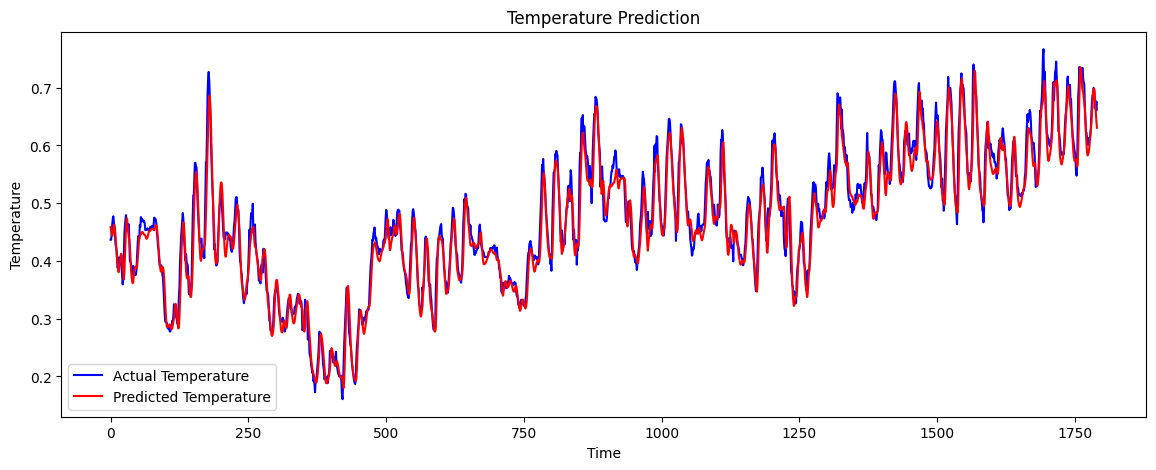

In [19]:
# Plotting predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test_actual, color='blue', label='Actual Temperature')
plt.plot(predictions, color='red', label='Predicted Temperature')
plt.title('Temperature Prediction')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# 9. Residual analysis

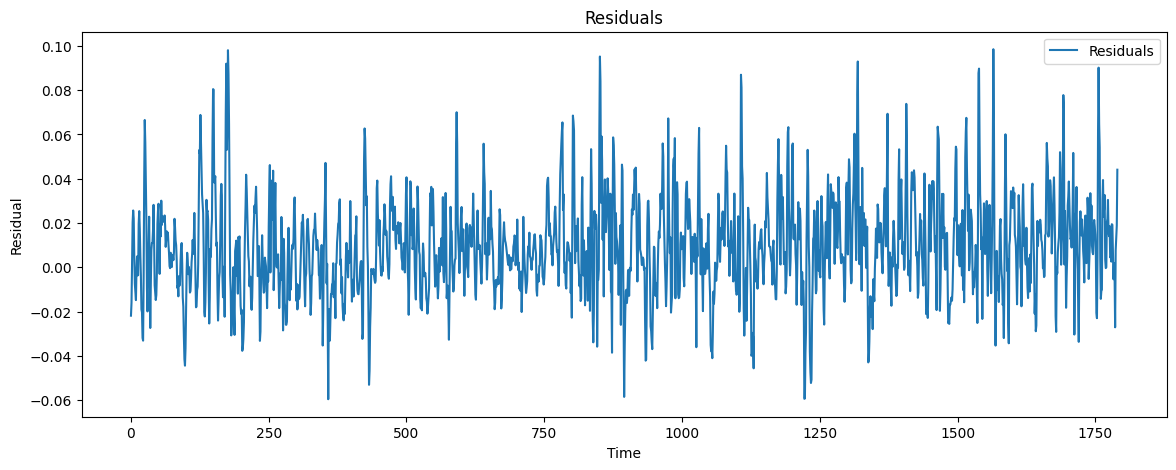

In [22]:
# Residual analysis
residuals = y_test_actual - predictions
plt.figure(figsize=(14, 5))
plt.plot(residuals, label='Residuals')
plt.title('Residuals')
plt.xlabel('Time')
plt.ylabel('Residual')
plt.legend()
plt.show()

# 10. Histogram of residuals

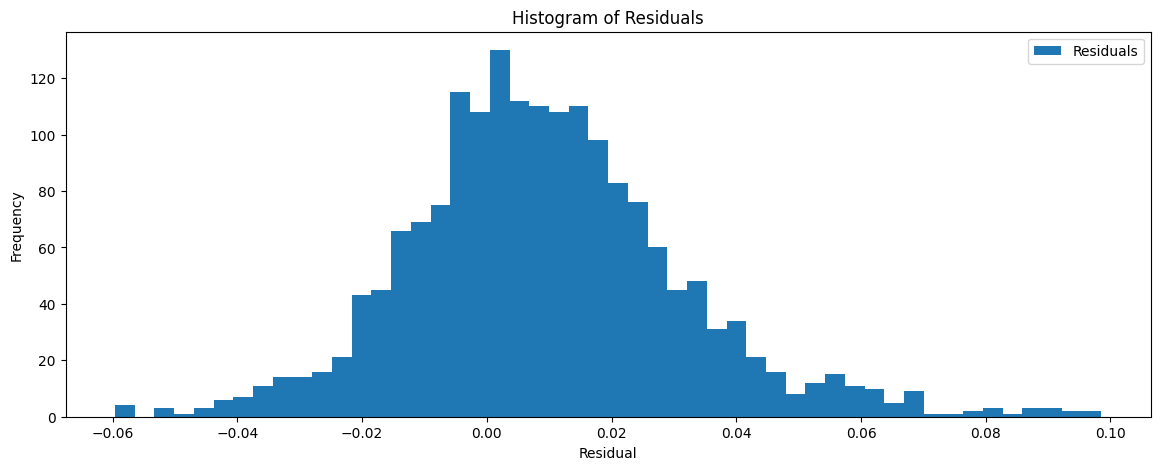

In [23]:
plt.figure(figsize=(14, 5))
plt.hist(residuals, bins=50, label='Residuals')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.show()

 We can potentially improve this performance, by changing the hyperparameters, adding more layers, or even changing the activation functions.
 Following is the same model trained by after some hyperparameter tuning is done.